In [1]:
%matplotlib inline

In [2]:
location="psi"

In [3]:
import sys

#add xgboost
sys.path += ["/mnt/t3nfs01/data01/shome/jpata/xgboost/python-package"]

import copy
from collections import OrderedDict

#add CMSCSTagger
if location=="jpata-macbook":
    sys.path.append("/Users/joosep/Documents/btv/CMSSW_7_4_5/src/RecoBTag/CombinedMVA/python/")
elif location=="psi":
    sys.path.append("/mnt/t3nfs01/data01/shome/jpata/btv/CMSSW_8_1_0/src/RecoBTag/CMSCSTagger/python/")

import numpy as np
import root_numpy as rnpy
import pandas
import dask

from matplotlib.colors import LogNorm
import rootpy
import rootpy.plotting

import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold, ShuffleSplit

import ROOT

import matplotlib.pyplot as plt
import seaborn

import xgboost

import rootpy.plotting.root2matplotlib as rplt

#import the CMSCSTagger training library
import sklearn_cls

from pandas.tools.plotting import scatter_matrix

Welcome to ROOTaaS 6.06/08


/swshare/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [141]:
seaborn.set_style("white")
current_palette = seaborn.color_palette()

Here we load the prepared training data.

In [6]:
vs = ["Jet_CSV", "Jet_CSVIVF", "Jet_JP", "Jet_JBP", "Jet_SoftMu", "Jet_SoftEl"]

In [108]:
fn = "/scratch/jpata/ttjets_tagvar_sub1000.root"
dd = pandas.concat([sklearn_cls.preprocess(sklearn_cls.load_data(
    fn,
    "tree_{0}".format(fl),
    branches=vs + ["Jet_flavour", "Jet_pt", "Jet_eta", "index", "Jet_cMVA"],
    selection="index>=5"
    #start=0,
    #stop=500000
    )) for fl in ["b", "c", "l"]])
unique_classes = dd["flavour_category"].unique()

INFO:root:loading data from /scratch/jpata/ttjets_tagvar_sub1000.root:tree_b
INFO:root:loaded data with shape (1520455, 11)
INFO:root:memory usage: 5.79 MB
INFO:root:preprocessing data
DEBUG:root:normalize_col_inplace Jet_CSV
DEBUG:root:normalize_col_inplace Jet_CSVIVF
DEBUG:root:normalize_col_inplace Jet_JP
DEBUG:root:normalize_col_inplace Jet_JBP
DEBUG:root:normalize_col_inplace Jet_SoftMu
DEBUG:root:normalize_col_inplace Jet_SoftEl
DEBUG:root:normalize_col_inplace Jet_cMVA
INFO:root:loading data from /scratch/jpata/ttjets_tagvar_sub1000.root:tree_c
INFO:root:loaded data with shape (1114905, 11)
INFO:root:memory usage: 5.79 MB
INFO:root:preprocessing data
DEBUG:root:normalize_col_inplace Jet_CSV
DEBUG:root:normalize_col_inplace Jet_CSVIVF
DEBUG:root:normalize_col_inplace Jet_JP
DEBUG:root:normalize_col_inplace Jet_JBP
DEBUG:root:normalize_col_inplace Jet_SoftMu
DEBUG:root:normalize_col_inplace Jet_SoftEl
DEBUG:root:normalize_col_inplace Jet_cMVA
INFO:root:loading data from /scratch/j

In [109]:
dd.loc[dd["Jet_pt"]>300, "Jet_SoftEl"] = 0

In [110]:
shuf_index = np.random.permutation(dd.index)

In [111]:
dd["flavour_category"].value_counts()

0    1636490
2    1520455
1    1114905
Name: flavour_category, dtype: int64

In [112]:
dd["is_training"].value_counts()

True     3417480
False     854370
Name: is_training, dtype: int64

Let's take a quick look at what we have.

In [113]:
dd.head()

,Jet_CSV,Jet_CSVIVF,Jet_JP,Jet_JBP,Jet_SoftMu,Jet_SoftEl,Jet_flavour,Jet_pt,Jet_eta,index,Jet_cMVA,flavour_category,is_training,weight,ptbin,ptbin2,etabin,etabin2
0,0.978913,0.990861,0.804723,5.605900,0.594313,0.000000,5.0,39.122967,1.633889,5,0.998388,2,True,1.0,1,2,7,7
1,0.992589,0.992645,1.178208,6.663527,0.574687,0.000000,5.0,55.416348,-1.019136,6,0.999542,2,True,1.0,1,4,5,5
2,0.795387,0.967506,0.510466,2.600580,0.000000,0.000000,5.0,42.263222,-0.533053,7,0.942276,2,True,1.0,1,3,3,3
3,0.947329,0.989906,0.821493,3.553031,0.000000,0.018209,5.0,27.040291,-1.323112,8,0.988996,2,True,1.0,1,1,6,6
4,0.992086,0.992208,1.751112,7.134807,0.000000,0.000000,5.0,80.787743,-0.670075,9,0.999789,2,False,1.0,2,7,3,3


Now we calculate the kinematic weights.

In [114]:
weights_class = {
    fl: sklearn_cls.get_weights(dd.ix[dd["flavour_category"] == fl], sklearn_cls.ptbins, sklearn_cls.etabins)
    for fl in unique_classes
}

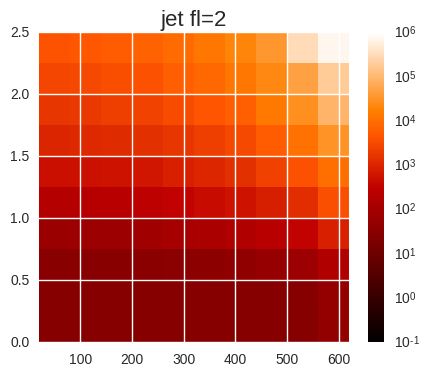

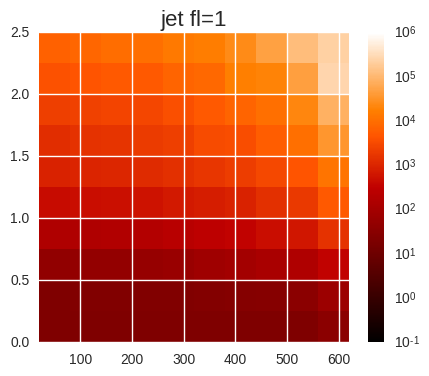

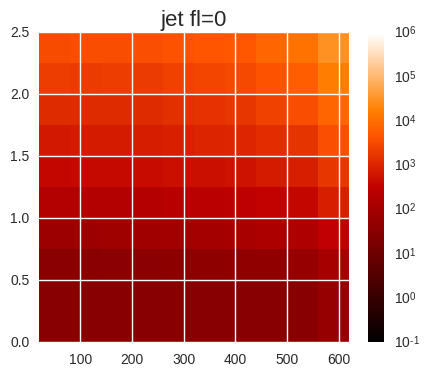

In [115]:
for fl in unique_classes:
    plt.figure(figsize=(5, 4))
    plt.title("jet fl={0}".format(fl), fontsize=16)
    z = plt.imshow(
        weights_class[fl],
        interpolation="none",
        origin="lower",
        norm=LogNorm(vmin=0.1,vmax=1000000.0),
        cmap="gist_heat",
        extent=(sklearn_cls.ptbins[0], sklearn_cls.ptbins[-1], sklearn_cls.etabins[0], sklearn_cls.etabins[-1]),
        aspect="auto"
    )
    plt.colorbar(z)
    #plt.xticks(ptbins)
    #plt.yticks(etabins)

In [116]:
def weight(pt, eta, fl, weights_class, ptbins, etabins):
    ibx = ptbins.searchsorted(pt) - 1
    iby = etabins.searchsorted(abs(eta)) - 1
    if ibx>=len(ptbins)-1:
        ibx = len(ptbins)-2
    if iby>=len(etabins)-1:
        iby = len(etabins)-2
        
    return weights_class[fl][ibx, iby]  

In [117]:
dd["weight"]  = map(
    lambda _z: weight(_z[0], _z[1], _z[2], weights_class, sklearn_cls.ptbins, sklearn_cls.etabins),
    zip(dd["Jet_pt"], dd["Jet_eta"].abs(), dd["flavour_category"])
)

In [118]:
def draw_corr(data, v1, vn1, v2, vn2, title):

    c = (np.abs(data["Jet_CSV"] -
         data["Jet_CSVIVF"])>0.00000000001
    )
    hd = np.histogram2d(
        data[c][v1],
        data[c][v2],
        bins=[np.linspace(0,1,21), np.linspace(0,1,21)]
    )
    hd = hd[0] / float(np.sum(hd[0]))
    corr = np.corrcoef(
        data[c][v1],
        data[c][v2]
    )

    plt.figure(figsize=(6,5))
    ax = plt.axes()
    ret = ax.imshow(
        hd,
        cmap="hot",
        interpolation="none",
        origin="lower",
        aspect="auto",
        #vmin=0,
        #vmax=60000,
        extent=[
            0,
            1,
            0,
            1
        ],
        norm=LogNorm(vmin=0.000001, vmax=1)
    )
    plt.title(title + " corr={0:.4f}".format(corr[0,1]), fontsize=16)
    plt.xlabel(vn1, fontsize=16)
    plt.ylabel(vn2, fontsize=16)
    plt.colorbar(ret)

Pt distribution before and after reweighting.

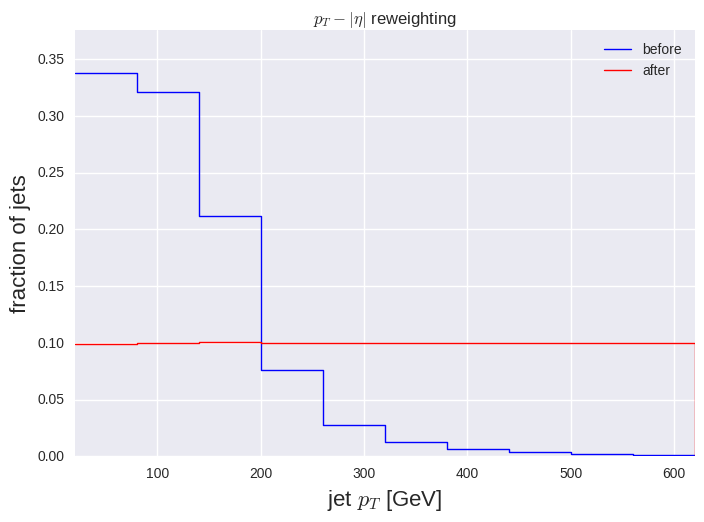

In [119]:
h = rootpy.plotting.Hist(sklearn_cls.ptbins)
w = np.ones(len(dd), dtype="float64")
h.FillN(len(dd), np.array(dd["Jet_pt"]).astype("float64"), w)
h.Scale(1.0 / h.Integral())
h.color="blue"
rplt.hist(h, color="blue", label="before")

h2 = rootpy.plotting.Hist(sklearn_cls.ptbins)
h2.FillN(len(dd), np.array(dd["Jet_pt"]).astype("float64"), np.array(dd["weight"]).astype("float64"))
h2.Scale(1.0 / h2.Integral())
h2.color="red"
rplt.hist(h2, color="red", label="after")

#plt.yscale("log")
#plt.ylim(10**-5, 1)
plt.xlabel("jet $p_T$ [GeV]", fontsize=16)
plt.ylabel("fraction of jets", fontsize=16)
plt.legend()
plt.title("$p_T-|\eta|$ reweighting")
plt.savefig("pt_reweight.pdf")

Eta distribution before and after reweighting.

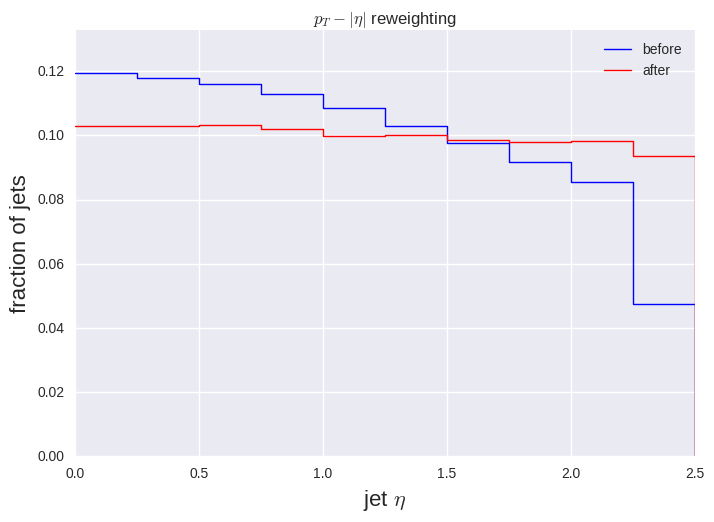

In [120]:
h = rootpy.plotting.Hist(sklearn_cls.etabins)
w = np.ones(len(dd), dtype="float64")
h.FillN(len(dd), np.array(dd["Jet_eta"].abs()).astype("float64"), w)
h.Scale(1.0 / h.Integral())
h.color="blue"
rplt.hist(h, color="blue", label="before")

h2 = rootpy.plotting.Hist(sklearn_cls.etabins)
h2.FillN(len(dd), np.array(dd["Jet_eta"].abs()).astype("float64"), np.array(dd["weight"]).astype("float64"))
h2.Scale(1.0 / h2.Integral())
h2.color="red"
rplt.hist(h2, color="red", label="after")

#plt.yscale("log")
#plt.ylim(10**-5, 1)
plt.xlabel("jet $\eta$", fontsize=16)
plt.ylabel("fraction of jets", fontsize=16)
plt.legend()
plt.title("$p_T-|\eta|$ reweighting")
plt.savefig("eta_reweight.pdf")

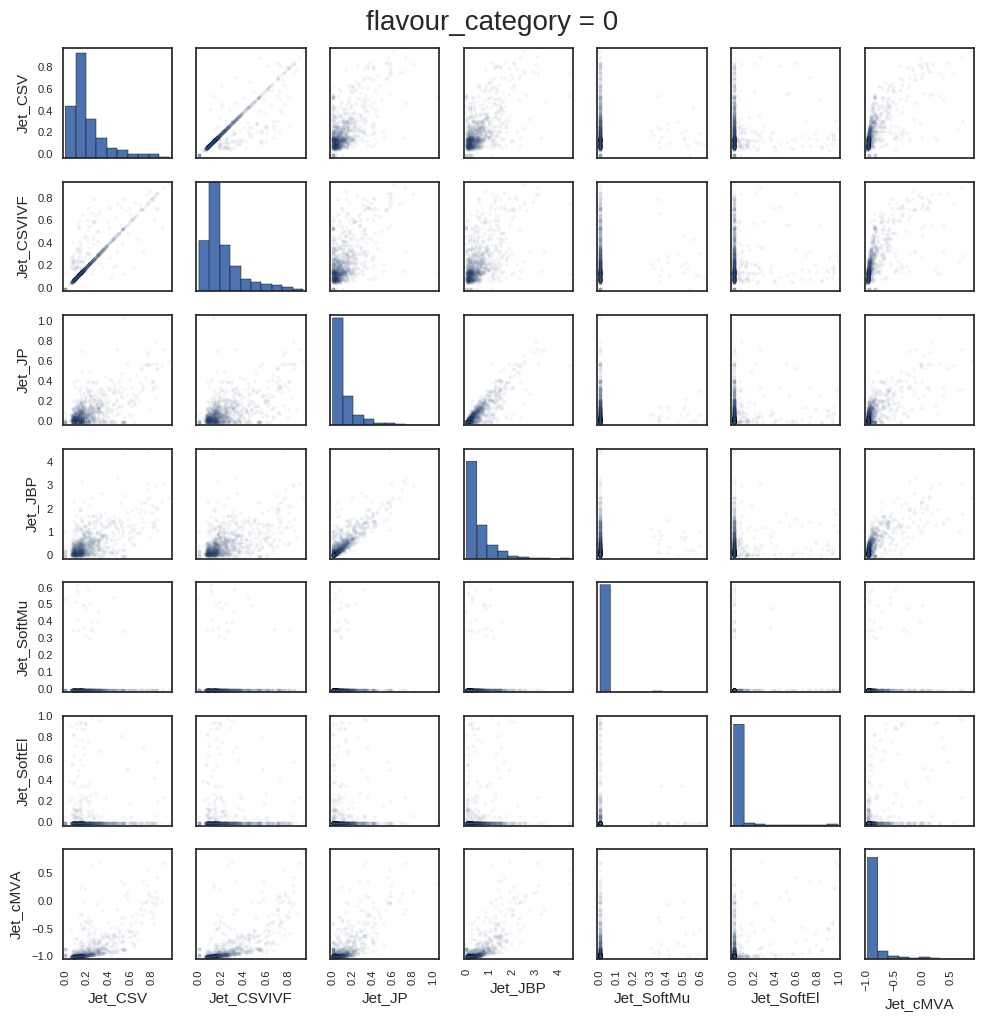

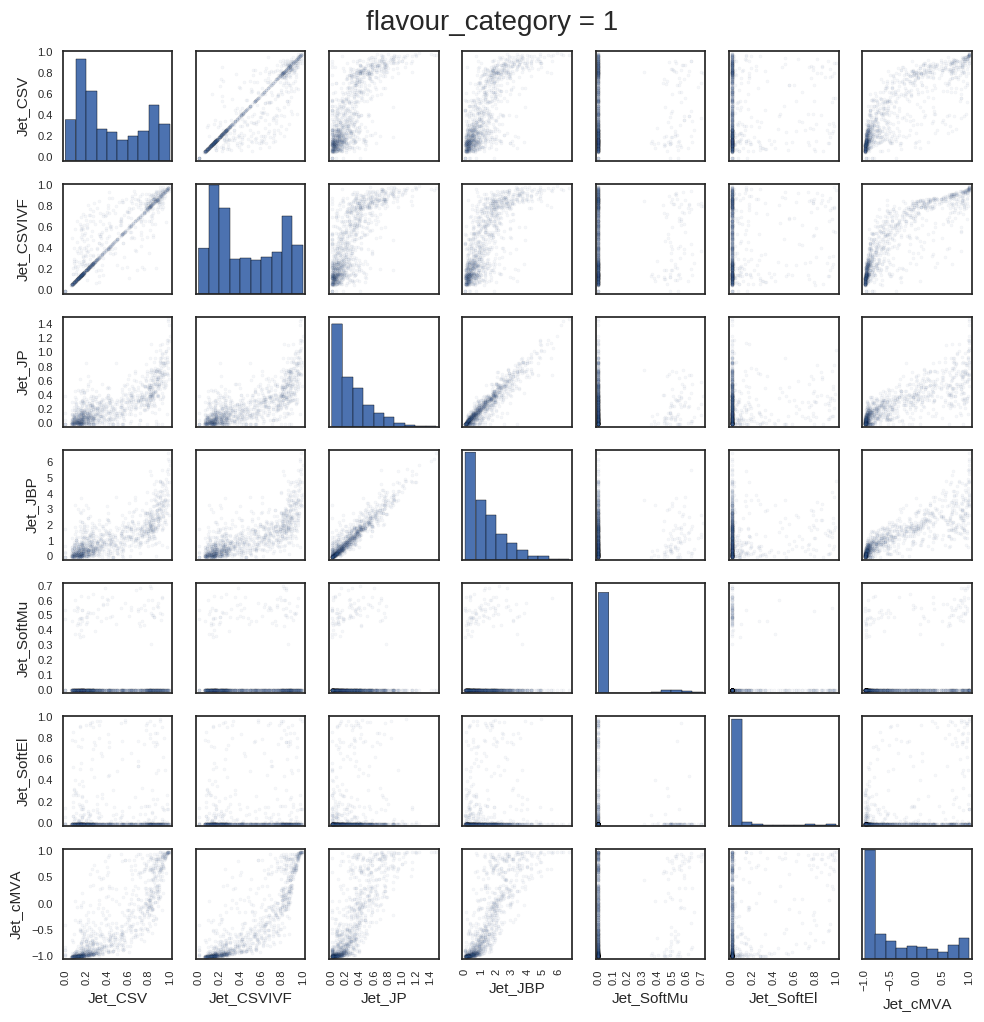

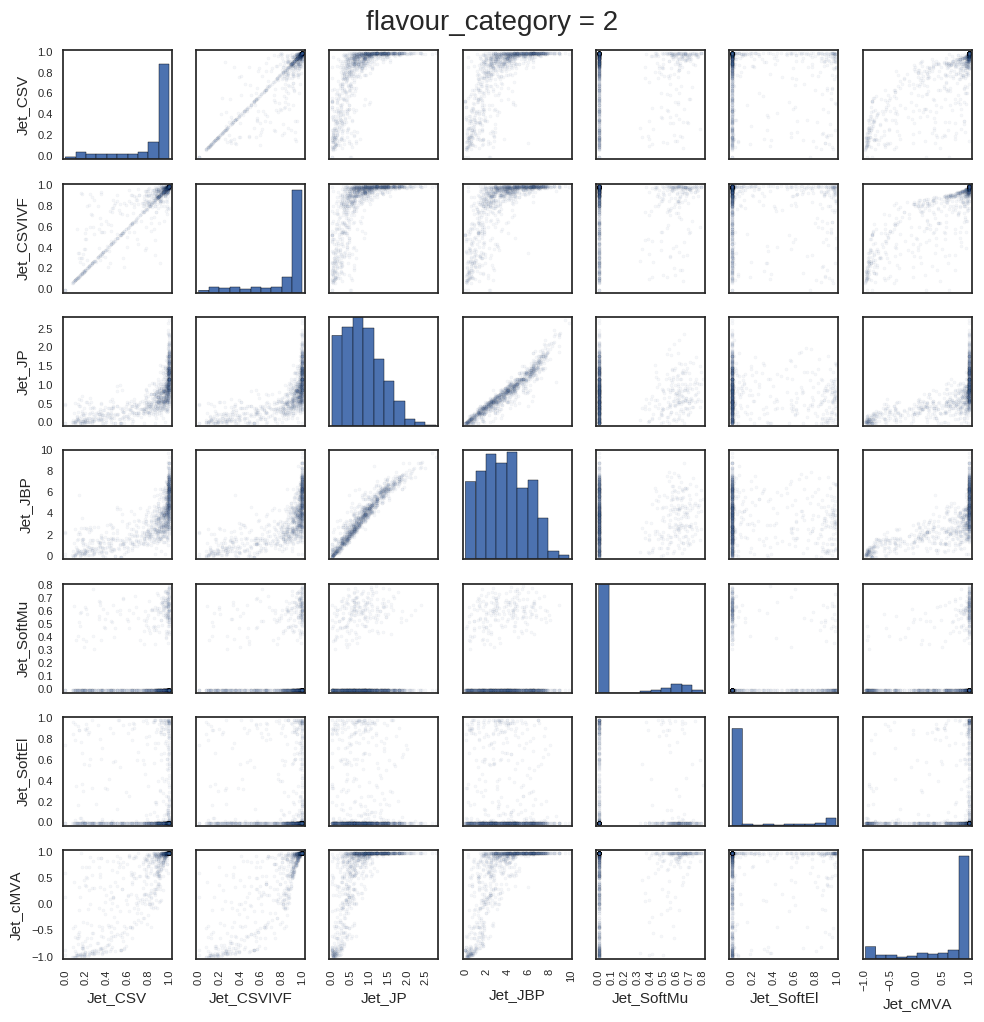

In [142]:
for igroup, (name, group) in enumerate(dd.groupby("flavour_category")):
    scatter_matrix(group.head(1000)[vs + ["Jet_cMVA"]], alpha=0.05, figsize=(10, 10), diagonal='hist')
    seaborn.plt.suptitle("flavour_category = {0}".format(name), fontsize=20, y=1.02)
    seaborn.plt.tight_layout()

In [122]:
is_training = dd["is_training"]==1

In [123]:
eval_set = [
    #training set, ttjets
    (dd.ix[is_training, vs], dd.ix[is_training, "flavour_category"]==2, dd.ix[is_training, "weight"]),
    #testing set
    (dd.ix[np.invert(is_training), vs], dd.ix[np.invert(is_training), "flavour_category"]==2, dd.ix[np.invert(is_training), "weight"])
]

In [124]:
dd.groupby(["flavour_category", "is_training"]).apply(lambda x: len(x))

flavour_category  is_training
0                 False           327298
                  True           1309192
1                 False           222981
                  True            891924
2                 False           304091
                  True           1216364
dtype: int64

In [125]:
cls = xgboost.XGBClassifier(n_estimators=500, nthread=32)
#cls2 = xgboost.XGBClassifier(n_estimators=500, nthread=32)

In [126]:
cls.fit(eval_set[0][0], eval_set[0][1], eval_set=eval_set, eval_metric=["error"], verbose=False)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=32,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [127]:
#cls2.fit(eval_set[0][0], eval_set[0][1], sample_weight=eval_set[0][2], eval_set=eval_set, eval_metric=["error"], verbose=False)

In [128]:
fpr_main, tpr_main, _ = sklearn.metrics.roc_curve(
    eval_set[0][1],
    cls.predict_proba(eval_set[0][0])[:, 1]
)
res_main = cls.evals_result()

In [129]:
dd["cls_p1"] = cls.predict_proba(dd[vs])[:, 1]
#dd["cls_p2"] = cls2.predict_proba(dd[vs])[:, 1]

# dd["cls2_p2"] = dd_cls[:, 2]

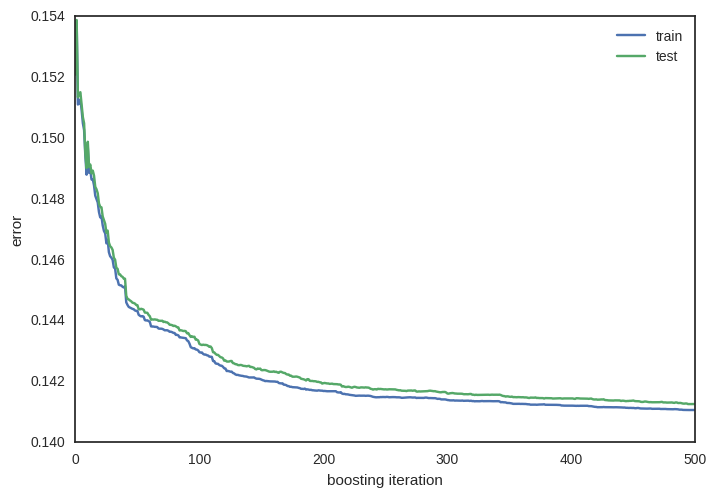

In [145]:
plt.plot(res_main["validation_0"]["error"], label="train")
plt.plot(res_main["validation_1"]["error"], label="test")
plt.legend()
plt.xlabel("boosting iteration")
plt.ylabel("error")

In [29]:
rets_cv = sklearn_cls.train_crossvalidation(cls, eval_set[0])

INFO:root:Training crossvalidation 6920404:768934
INFO:root:Training crossvalidation 6920404:768934
INFO:root:Training crossvalidation 6920404:768934
INFO:root:Training crossvalidation 6920404:768934
INFO:root:Training crossvalidation 6920404:768934


[11:40:30] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[11:44:42] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[11:48:55] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[11:53:12] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[11:57:30] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'


[ 0.07820939  0.07815577  0.07861977  0.07888487  0.07888992]


(0.01, 1.0)

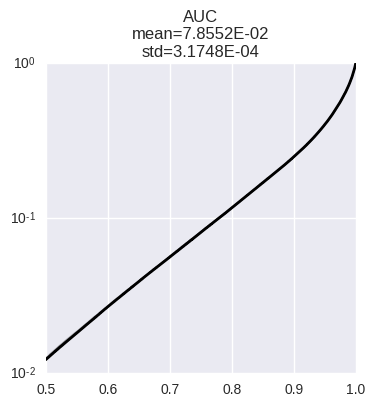

In [30]:
plt.figure(figsize=(4,4))
for tpr, fpr in rets_cv:
    plt.plot(tpr, fpr, color="black", lw=1, alpha=0.3)
plt.plot(tpr_main, fpr_main, color="black", lw=2)
aucs = np.array([sklearn.metrics.auc(tpr, fpr) for (tpr, fpr) in rets_cv])
print aucs
plt.title("AUC\nmean={0:.4E}\nstd={1:.4E}".format(np.mean(aucs), np.std(aucs)))
plt.yscale("log")
plt.xlim(0.5, 1.0)
plt.ylim(0.01, 1.0)

In [31]:
rets_varremove = sklearn_cls.train_variable_remove(cls, eval_set[0], eval_set[1])

INFO:root:Training variable remove with -Jet_CSV
INFO:root:Training variable remove with -Jet_CSVIVF
INFO:root:Training variable remove with -Jet_JP
INFO:root:Training variable remove with -Jet_JBP
INFO:root:Training variable remove with -Jet_SoftMu
INFO:root:Training variable remove with -Jet_SoftEl


[12:01:42] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[12:06:17] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[12:11:00] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[12:15:25] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[12:19:48] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[12:24:23] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machi

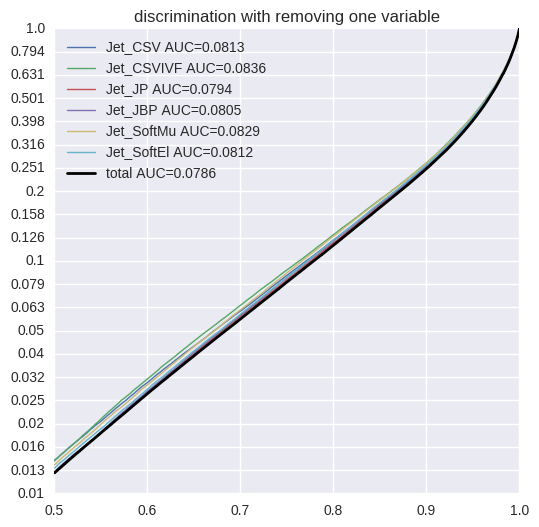

In [32]:
plt.figure(figsize=(6,6))
plt.title("discrimination with removing one variable")
for (tpr, fpr), var in zip(rets_varremove[0], rets_varremove[1]):
    plt.plot(tpr, fpr, label="{0} AUC={1:.4f}".format(var, sklearn.metrics.auc(tpr, fpr)), lw=1)

plt.plot(
    tpr_main,
    fpr_main,
    color="black",
    lw=2,
    label="{0} AUC={1:.4f}".format(
        "total", sklearn.metrics.auc(tpr_main, fpr_main))
    )
plt.yscale("log")
plt.xlim(0.5, 1.0)
plt.ylim(0.01, 1.0)
ts = np.logspace(-2, 0, 21)
plt.yticks(ts, [round(x, 3) for x in ts])
plt.legend(loc="best")

In [38]:
def compare_classes(c1, c2, dd, probas):
    """
    c1 (int): first category, e.g. signal
    c2 (int): second category, e.g. background
    dd (dataframe): dataframe with the classification outputs
    probas (list of strings): discriminators to evaluate
    """
    is_c1 = dd["flavour_category"] == c1
    is_c2 = dd["flavour_category"] == c2
    rocs = []
    for cls_proba in probas:
        fpr, tpr, _ = sklearn.metrics.roc_curve(
            dd.loc[is_c1|is_c2, "flavour_category"] == c1, #events that are from category c1
            dd.loc[is_c1|is_c2, cls_proba]
        )
        rocs += [(fpr, tpr, cls_proba)]
    return rocs

In [39]:
pairs = []
for c1 in unique_classes:
    for c2 in unique_classes:
        if c1 == c2:
            continue
        if (c1, c2) in pairs or (c2, c1) in pairs:
            continue
        pairs += [(c1, c2)]

In [40]:
rocs = []
for p in pairs:
    rocs += [
        (p, compare_classes(p[0], p[1], dd[dd["is_training"]==0], ["Jet_CSVIVF", "Jet_cMVA", "cls_p1"]))
    ]

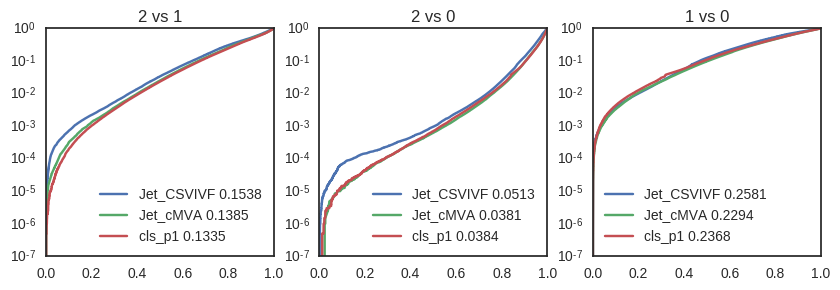

In [144]:
plt.figure(figsize=(10, 10))

ipl = 1
for pair, roc in rocs:
    plt.subplot(3, 3, ipl)
    for fpr, tpr, label in roc:
        plt.plot(tpr, fpr, label=label + " {0:.4f}".format(sklearn.metrics.auc(tpr, fpr)))
    plt.title("{0} vs {1}".format(pair[0], pair[1]))
    plt.yscale("log")
    #plt.xlim(0.5, 1.0)
    #plt.ylim(0.001, 1.0)
    plt.legend(loc="best")
    ipl += 1

In [42]:
def get_auc_by_group(c1, c2, discs, col):
    """
    c1 (int): first category, e.g. signal
    c2 (int): second category, e.g. background
    discs (list of strings): discriminators to plot
    col (string): column to split on
    """
    vals = {d: [] for d in discs}
    vals_err = {d: [] for d in discs}
    for grname, gr in dd[dd["is_training"]==0].groupby(col):
        vals_bin = {d: [] for d in discs}
        
        #randomly select subsample of events to calculate metric on
        kf = ShuffleSplit(n_splits = 5)
        for train, test in kf.split(shuf_index):
            
            rocs = compare_classes(c1, c2, gr.ix[train], discs)
            for disc, r in zip(discs, rocs):
                vals_bin[disc] += [sklearn.metrics.auc(r[1], r[0])]
        for d in discs:
            vals[d] += [np.mean(vals_bin[d])]
            vals_err[d] += [np.std(vals_bin[d])]
    return vals, vals_err

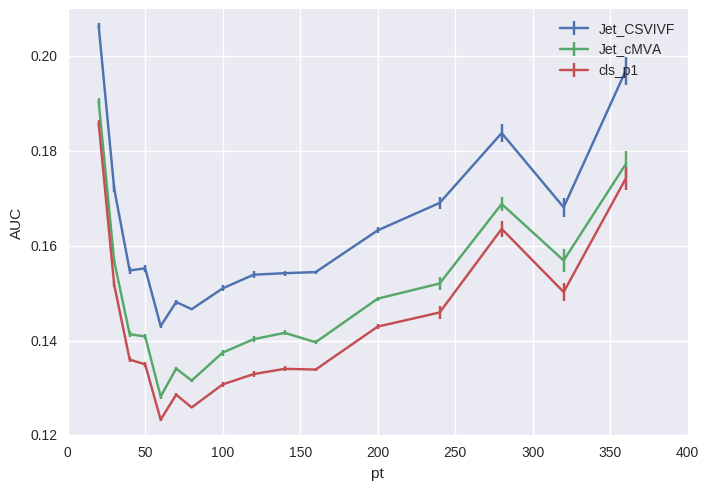

In [44]:
discs = ["Jet_CSVIVF", "Jet_cMVA", "cls_p1"]
vals, vals_err = get_auc_by_group(2, 1, discs, "ptbin2")
for d in discs:
    plt.errorbar(sklearn_cls.ptbins2, vals[d], yerr=vals_err[d], label=d)
plt.legend()
plt.xlabel("pt")
plt.ylabel("AUC")

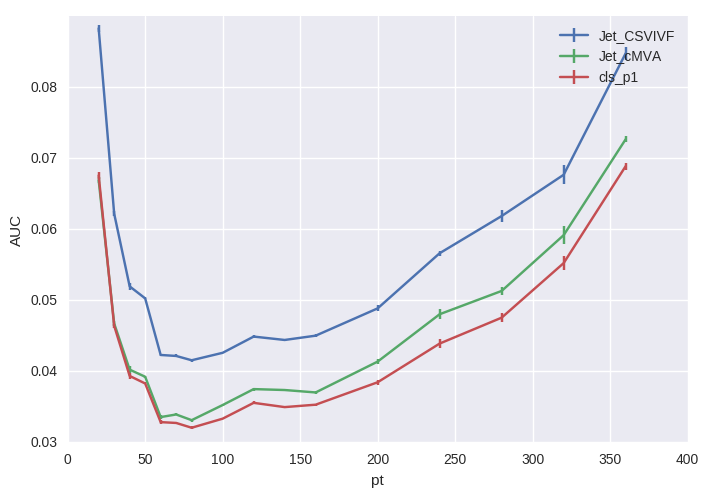

In [45]:
discs = ["Jet_CSVIVF", "Jet_cMVA", "cls_p1"]
vals, vals_err = get_auc_by_group(2, 0, discs, "ptbin2")
for d in discs:
    plt.errorbar(sklearn_cls.ptbins2, vals[d], yerr=vals_err[d], label=d)
plt.legend()
plt.xlabel("pt")
plt.ylabel("AUC")

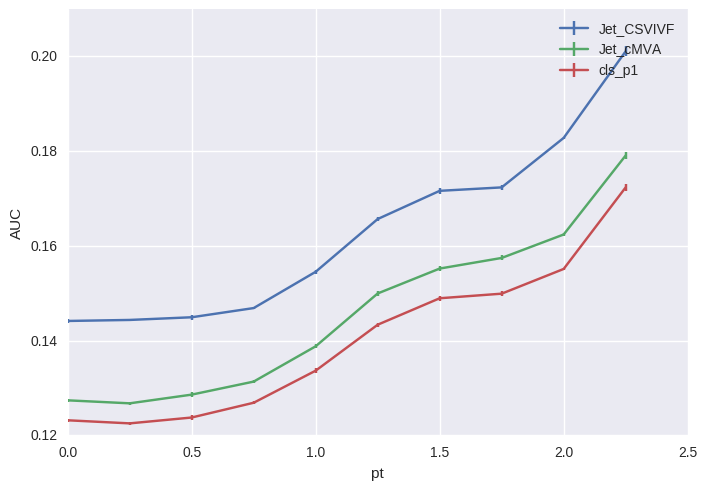

In [46]:
discs = ["Jet_CSVIVF", "Jet_cMVA", "cls_p1"]
vals, vals_err = get_auc_by_group(2, 1, discs, "etabin2")
for d in discs:
    plt.errorbar(sklearn_cls.etabins2[:-1], vals[d], yerr=vals_err[d], label=d)
plt.legend()
plt.xlabel("pt")
plt.ylabel("AUC")

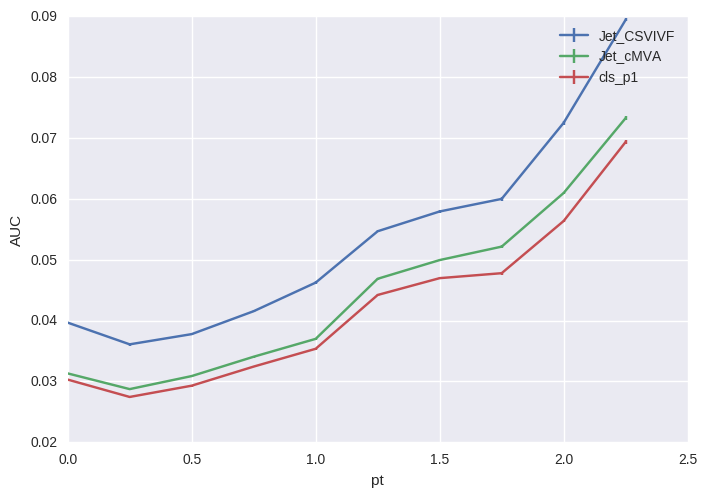

In [47]:
discs = ["Jet_CSVIVF", "Jet_cMVA", "cls_p1"]
vals, vals_err = get_auc_by_group(2, 0, discs, "etabin2")
for d in discs:
    plt.errorbar(sklearn_cls.etabins2[:-1], vals[d], yerr=vals_err[d], label=d)
plt.legend()
plt.xlabel("pt")
plt.ylabel("AUC")

In [72]:
fn = "/scratch/jpata/ttjets_tagvar_all.root"
dd2 = pandas.concat([sklearn_cls.preprocess(sklearn_cls.load_data(
    fn,
    "tree_{0}".format(fl),
    #selection="index>=8"
    start=0,
    stop=2000000,
    branches=vs + ["Jet_flavour", "Jet_pt", "Jet_eta", "index", "Jet_cMVA"]
    )) for fl in ["b", "c", "l"]])

INFO:root:loading data from /scratch/jpata/ttjets_tagvar_all.root:tree_b
INFO:root:loaded data with shape (2000000, 11)
INFO:root:memory usage: 3.81 MB
INFO:root:preprocessing data
DEBUG:root:normalize_col_inplace Jet_CSV
DEBUG:root:normalize_col_inplace Jet_CSVIVF
DEBUG:root:normalize_col_inplace Jet_JP
DEBUG:root:normalize_col_inplace Jet_JBP
DEBUG:root:normalize_col_inplace Jet_SoftMu
DEBUG:root:normalize_col_inplace Jet_SoftEl
DEBUG:root:normalize_col_inplace Jet_cMVA
INFO:root:loading data from /scratch/jpata/ttjets_tagvar_all.root:tree_c
INFO:root:loaded data with shape (2000000, 11)
INFO:root:memory usage: 3.81 MB
INFO:root:preprocessing data
DEBUG:root:normalize_col_inplace Jet_CSV
DEBUG:root:normalize_col_inplace Jet_CSVIVF
DEBUG:root:normalize_col_inplace Jet_JP
DEBUG:root:normalize_col_inplace Jet_JBP
DEBUG:root:normalize_col_inplace Jet_SoftMu
DEBUG:root:normalize_col_inplace Jet_SoftEl
DEBUG:root:normalize_col_inplace Jet_cMVA
INFO:root:loading data from /scratch/jpata/ttj

In [131]:
dd2.loc[dd2["Jet_pt"]>300, "Jet_SoftEl"] = 0

In [132]:
x = cls.predict_proba(dd2[vs])[:, 1]

In [133]:
dd2["cls_p1"] = x

In [134]:
rocs = []
for p in pairs:
    rocs += [
        (p, compare_classes(p[0], p[1], dd2, ["Jet_CSVIVF", "Jet_cMVA", "cls_p1"]))
    ]

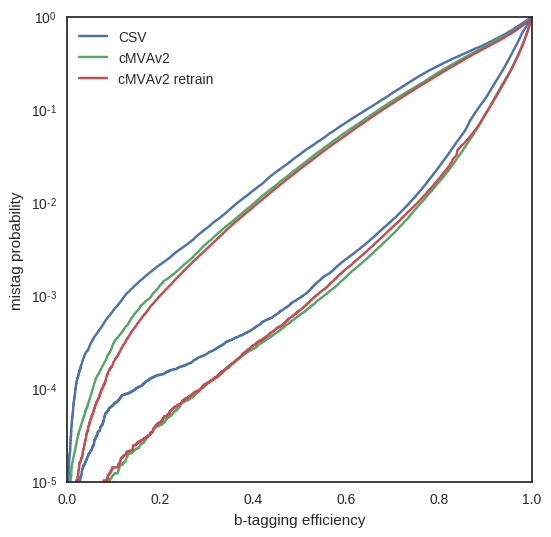

In [140]:
plt.figure(figsize=(6,6))
ax = plt.axes()

plt.plot(rocs[0][1][0][1], rocs[0][1][0][0], color=current_palette[0])
plt.plot(rocs[0][1][1][1], rocs[0][1][1][0], color=current_palette[1])
plt.plot(rocs[0][1][2][1], rocs[0][1][2][0], color=current_palette[2])

plt.plot(rocs[1][1][0][1], rocs[1][1][0][0], color=current_palette[0], label="CSV")
plt.plot(rocs[1][1][1][1], rocs[1][1][1][0], color=current_palette[1], label="cMVAv2")
plt.plot(rocs[1][1][2][1], rocs[1][1][2][0], color=current_palette[2], label="cMVAv2 retrain")
plt.yscale("log")
plt.ylim(10**-5, 1)
plt.legend(loc="best")
plt.xlabel("b-tagging efficiency")
plt.ylabel("mistag probability")

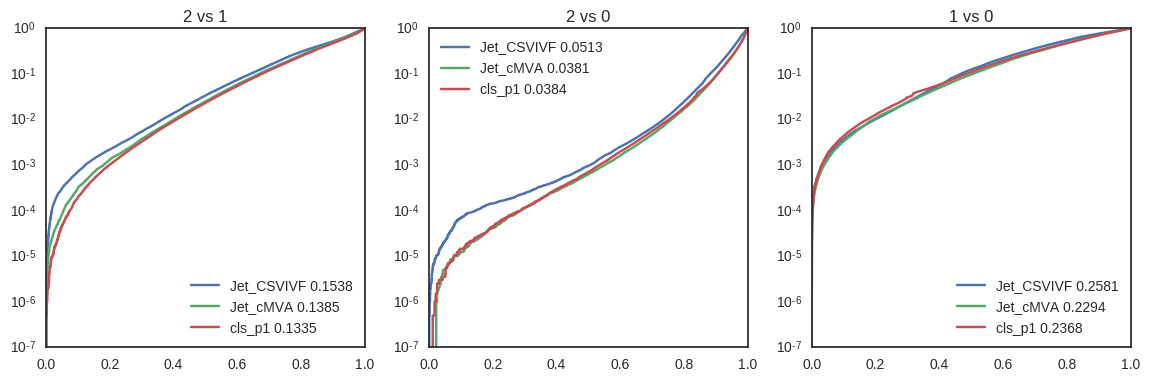

In [148]:
plt.figure(figsize=(14, 14))

ipl = 1
for pair, roc in rocs:
    plt.subplot(3, 3, ipl)
    for fpr, tpr, label in roc:
        plt.plot(tpr, fpr, label=label + " {0:.4f}".format(sklearn.metrics.auc(tpr, fpr)))
    plt.title("{0} vs {1}".format(pair[0], pair[1]))
    plt.yscale("log")
    #plt.xlim(0.5, 1.0)
    #plt.ylim(0.001, 1.0)
    plt.legend(loc="best")
    ipl += 1

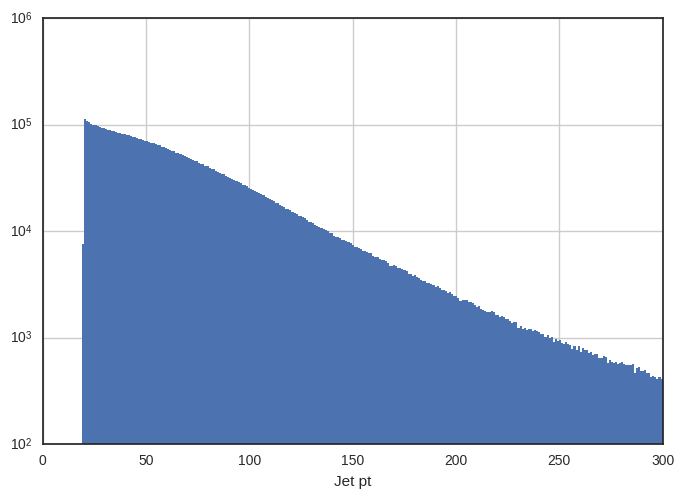

In [146]:
dd2["Jet_pt"].hist(bins=np.linspace(0, 300, 300), lw=0)
plt.yscale("log")
plt.xlabel("Jet pt")

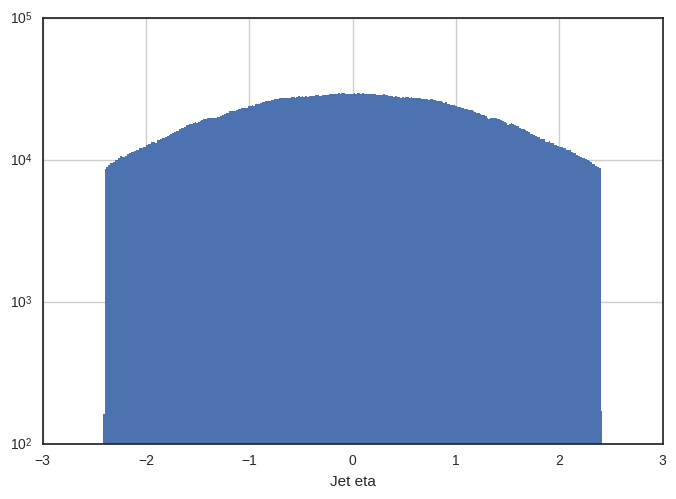

In [147]:
dd2["Jet_eta"].hist(bins=np.linspace(-2.5, 2.5, 300), lw=0)
plt.yscale("log")
plt.xlabel("Jet eta")